# Discretisation of the model

In this notebook a modified version of the 1D discretized Jarrah's model is implemented. Diffusive terms are added in the evolution of the concentration of immune cells and several possible boundary conditions are explored. Those conditions are labelled as "evolving_sym", "evolving_asym", "fixed_sym", "fixed_asym" and "periodic".

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os

### One-step update in the system's evolution

In [19]:
def one_step(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

### Damage function

In [20]:
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Diffusion functions
Possible boundary conditions:
- periodic
- evolving_sym: the rightmost and leftmost cells are initialized in the same way and evolve like the inner ones
- evolving_asym: the rightmost and leftmost cells are initialized differently and evolve like the inner ones
- fixed_sym: the rightmost and leftmost cells are initialized in the same way and cannot evolve
- fixed_asym: the rightmost and leftmost cells are initialised differently and cannot evolve

In [21]:
def diff_H(i, dx, D_H, H, boundary, precision=14):
    if boundary in ['evolving_sym', 'evolving_asym', 'fixed_sym', 'fixed_asym']:
        if i == 0:
                diff = H[i+1] - H[i]
        elif i == len(H) - 1:
            diff = H[i-1] - H[i]
        else:
            diff = H[i+1] + H[i-1] - 2 * H[i]
    
    elif boundary == 'periodic':
        if i == 0:
            diff = H[i+1] + H[-1] - 2 * H[i]
        elif i == len(H) - 1:
            diff = H[0] + H[i-1] - 2 * H[i]
        else:
            diff = H[i+1] + H[i-1] - 2 * H[i]
    
#Round the relative difference to avoid small floating-point errors
    if round(diff / (abs(H[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_H / dx**2 * diff

def diff_C(i, dx, D_C, C, boundary, precision=14):
    if boundary in ['evolving_sym', 'evolving_asym', 'fixed_sym', 'fixed_asym']:
        if i == 0:
            diff = C[i+1] - C[i]
        elif i == len(C) - 1:
            diff = C[i-1] - C[i]
        else:
            diff = C[i+1] + C[i-1] - 2 * C[i]

    elif boundary == 'periodic':
        if i == 0:
            diff = C[i+1] + C[-1] - 2 * C[i]
        elif i == len(C) - 1:
            diff = C[0] + C[i-1] - 2 * C[i]
        else:
            diff = C[i+1] + C[i-1] - 2 * C[i]
        
    
    if round(diff / (abs(C[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_C / dx**2 * diff

def diff_M(i, dx, D_M, M, boundary, precision=14):
    if boundary in ['evolving_sym', 'evolving_asym', 'fixed_sym', 'fixed_asym']:
        if i == 0:
            diff = M[i+1] - M[i]
        elif i == len(M) - 1:
            diff = M[i-1] - M[i]
        else:
            diff = M[i+1] + M[i-1] - 2 * M[i]

    elif boundary == 'periodic':
        if i == 0:
            diff = M[i+1] + M[-1] - 2 * M[i]
        elif i == len(M) - 1:
            diff = M[0] + M[i-1] - 2 * M[i]
        else:
            diff = M[i+1] + M[i-1] - 2 * M[i]
    
    if round(diff / (abs(M[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_M / dx**2 * diff

### Evolution of the immune cells
The commented lines where dt is redefined can be used for a check on a possible modification of the discrete model based on the work of Professor Rondoni.

In [22]:
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary):

    #dt = dt * (1 - H[i] / 4500)**2
    
    if boundary in ['evolving_sym', 'evolving_asym', 'periodic']:
        H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H, boundary) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(H)-1:
            H_new[i] = H[i]
        else:
            H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H, boundary) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary):

    #dt = dt * (1 - C[i] / 450)**2
    
    if boundary in ['evolving_sym', 'evolving_asym', 'periodic']:
        C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C, boundary) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(C)-1:
            C_new[i] = C[i]
        else:
            C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C, boundary) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')
   
def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary):

    #dt = dt * (1 - M[i] / 100000)**2
    
    if boundary in ['evolving_sym', 'evolving_asym', 'periodic']:
        M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M, boundary) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(M)-1:
            M_new[i] = M[i]
        else:
            M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M, boundary) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')
            

### Evolution of the composition of muscle tissue

In [23]:
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
        
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
        
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])
    

### Save the output to a .csv file

In [24]:
def save_to_csv(output_list, column_name, directory, file_name):
#Ensure the directory exists and create the file path
    os.makedirs(directory, exist_ok=True)
    file_path = os.path.join(directory, file_name)
    
#Try to read the existing CSV file; if it doesn't exist, create an empty DataFrame
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

#Add the specified column with the output list and save the DataFrame
    df[column_name] = output_list
    df.to_csv(file_path, index=False)
            

### Function to retrieve information from the configuration file

In [25]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file.')
    return values

## Simulation

Parameters are stored in the config.ini file. The outputs are the variables *_values, which are lists of lists (every one storing the value of a specific state variable for every cell at every time step). These values can be saved in .csv files setting SAVE_csv to True.

In [26]:
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibres', 'damaged_fibres', 'regenerating_fibres']
N_VARS = len(labels)

#Create an instance of the ConfigParser class to read the configuration file
config = configparser.ConfigParser()
config.read('config.ini')

i_c = extract_values('initial_conditions_left', config)
par = extract_values('parameters', config)
diffusion = extract_values('diff_coeff', config)
sim = extract_values('simulation_par', config)

dt, t_min, t_max, dx, N_cells = sim
N_cells = int(N_cells)

if 'boundary_conditions' in config:
    for key, value in config['boundary_conditions'].items():
        boundary=value
else:
    print('Section "boundary_conditions" is not in the configuration file.')

'Asymmetric boundary conditions require additional initial conditions'
if boundary in ['evolving_asym','fixed_asym']:  
    i_c_r = extract_values('initial_conditions_right', config)
    
t = [t_min]

'''For each state variable, create three lists of N_cells values:
one to store the configuration of the system at the current step,
one containing the initial conditions,
and one to perform the temporal evolution.'''
H, C, M, N, D, R = [[i_c[i]] * N_cells for i in range(N_VARS)]
H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[i]] * N_cells for i in range(N_VARS)]
H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[i]] * N_cells for i in range(N_VARS)]

'''The initialization of the cells is uniform in this code; however, if an unbalanced boundary condition is required,
this must be taken into account by initializing the rightmost cell with new conditions.
In this way, the first N-1 cells are initialized like the left boundary, while the Nth cell is initialized differently.
Of course, other possible initializations can be explored for the central cells.'''
if boundary in ['evolving_asym','fixed_asym']:
    H[-1], C[-1], M[-1], N[-1], D[-1], R[-1] = i_c_r
    H_i[-1], C_i[-1], M_i[-1], N_i[-1], D_i[-1], R_i[-1] = i_c_r
    i_c.extend(i_c_r)

#These lists store the values of each state variable at every time step
H_values = [H.copy()]
C_values = [C.copy()]
M_values = [M.copy()]
N_values = [N.copy()]
D_values = [D.copy()]
R_values = [R.copy()]

for j in range(0, int((t_max-t_min)/dt)):

    one_step(t[j], dt, dx,
             H, C, M, N, D, R,
             H_new, C_new, M_new, N_new, D_new, R_new,
             H_i, C_i, M_i,
             par, diffusion, boundary
            )
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()   
    
    H_values.append([float(value) for value in H_new])
    C_values.append([float(value) for value in C_new])
    M_values.append([float(value) for value in M_new])
    N_values.append([float(value) for value in N_new])
    D_values.append([float(value) for value in D_new])
    R_values.append([float(value) for value in R_new])
    t.append((j + 1.) / (1./dt))   ###not the best way to write it, but somehow with multiplication it messes up

'''The output of the simulation will be stored in the path specified by "directory".'''
if boundary in ['periodic', 'evolving_sym']:
    directory = f'{N_cells}_cells_over_{t_max}w_with_dt_{dt}/{boundary}_ic_{i_c[0]}_{i_c[1]}_{i_c[2]}_{i_c[3]}_{i_c[4]}_{i_c[5]}/'
elif boundary == 'fixed_sym':
    directory = f'{N_cells}_cells_over_{t_max}w_with_dt_{dt}/{boundary}_ic_{i_c[0]}_{i_c[1]}_{i_c[2]}_{i_c[3]}_{i_c[4]}_{i_c[5]}/\
diffusion_{diffusion[0]}'
else:
    directory = f'{N_cells}_cells_over_{t_max}w_with_dt_{dt}/{boundary}_icl_{i_c[0]}_{i_c[1]}_{i_c[2]}_{i_c[3]}_{i_c[4]}_{i_c[5]}/\
icr_{i_c[6]}_{i_c[7]}_{i_c[8]}_{i_c[9]}_{i_c[10]}_{i_c[11]}/diffusion_{diffusion[0]}'

os.makedirs(directory, exist_ok=True)

'''The variable SAVE_csv is a boolean value that determines whether the output of the simulation is stored in .csv format.'''
SAVE_csv = False
if SAVE_csv:

    if boundary == 'fixed_sym':
        for i in range(round(N_cells / 2)):
            save_to_csv([row[i] for row in H_values], f'cell_{i}', directory, 'H.csv')
            save_to_csv([row[i] for row in C_values], f'cell_{i}', directory, 'C.csv')
            save_to_csv([row[i] for row in M_values], f'cell_{i}', directory, 'M.csv')
            save_to_csv([row[i] for row in N_values], f'cell_{i}', directory, 'N.csv')
            save_to_csv([row[i] for row in D_values], f'cell_{i}', directory, 'D.csv')
            save_to_csv([row[i] for row in R_values], f'cell_{i}', directory, 'R.csv')
    elif boundary in ['fixed_asym', 'evolving_asym']:
        for i in range(N_cells):
            save_to_csv([row[i] for row in H_values], f'cell_{i}', directory, 'H.csv')
            save_to_csv([row[i] for row in C_values], f'cell_{i}', directory, 'C.csv')
            save_to_csv([row[i] for row in M_values], f'cell_{i}', directory, 'M.csv')
            save_to_csv([row[i] for row in N_values], f'cell_{i}', directory, 'N.csv')
            save_to_csv([row[i] for row in D_values], f'cell_{i}', directory, 'D.csv')
            save_to_csv([row[i] for row in R_values], f'cell_{i}', directory, 'R.csv')
    else:
        save_to_csv(column_H_1, 'cell_1', directory, 'H.csv')
        save_to_csv(column_C_1, 'cell_1', directory, 'C.csv')
        save_to_csv(column_M_1, 'cell_1', directory, 'M.csv')
        save_to_csv(column_N_1, 'cell_1', directory, 'N.csv')
        save_to_csv(column_D_1, 'cell_1', directory, 'D.csv')
        save_to_csv(column_R_1, 'cell_1', directory, 'R.csv')

The result of the simulation is shown here. The following cell plots the evolution of each state variable in the second (and possibly the third and central) cell of the row. With uniform initialization, every cell's evolution is representative of the others under certain boundary conditions. However, if edge cells are fixed or initialized differently, the evolution of additional cells should also be studied. 

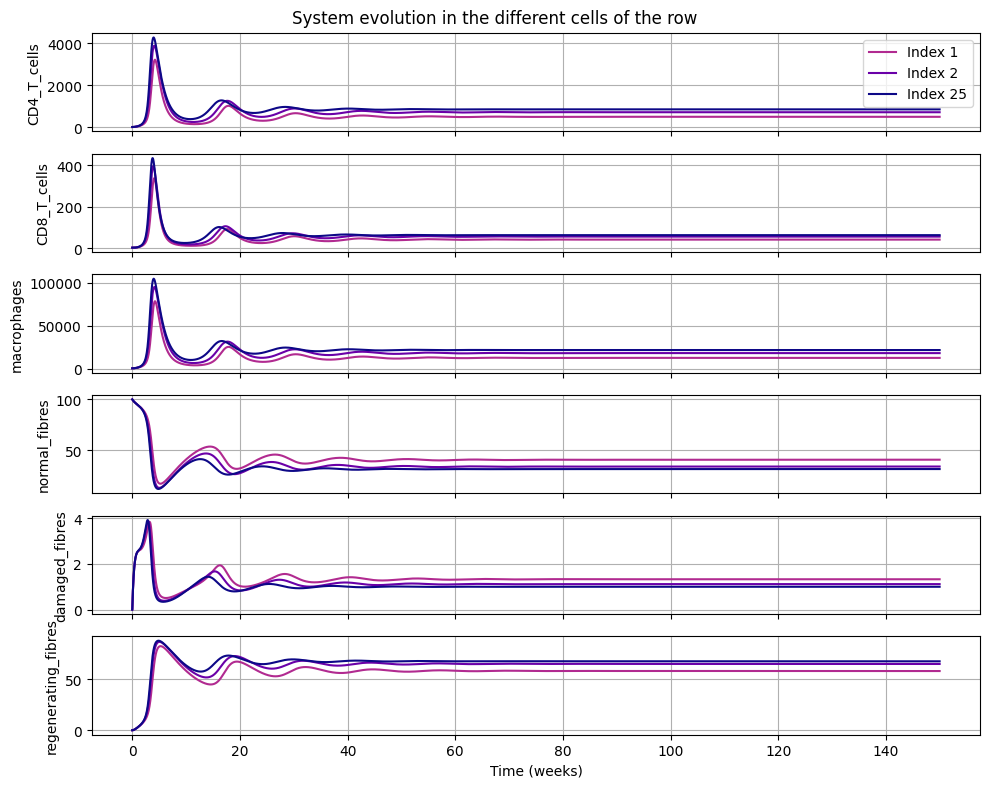

In [28]:
#Use list comprehensions to extract the second and third column, representing the evolution of the second and third cell
column_H_1 = [row[1] for row in H_values]
column_C_1 = [row[1] for row in C_values]
column_M_1 = [row[1] for row in M_values]
column_N_1 = [row[1] for row in N_values]
column_D_1 = [row[1] for row in D_values]
column_R_1 = [row[1] for row in R_values]

column_H_2 = [row[2] for row in H_values]
column_C_2 = [row[2] for row in C_values]
column_M_2 = [row[2] for row in M_values]
column_N_2 = [row[2] for row in N_values]
column_D_2 = [row[2] for row in D_values]
column_R_2 = [row[2] for row in R_values]

column_H_c = [row[int(N_cells * 0.5)] for row in H_values]
column_C_c = [row[int(N_cells * 0.5)] for row in C_values]
column_M_c = [row[int(N_cells * 0.5)] for row in M_values]
column_N_c = [row[int(N_cells * 0.5)] for row in N_values]
column_D_c = [row[int(N_cells * 0.5)] for row in D_values]
column_R_c = [row[int(N_cells * 0.5)] for row in R_values]

cell_1 = [column_H_1, column_C_1, column_M_1, column_N_1, column_D_1, column_R_1]
cell_2 = [column_H_2, column_C_2, column_M_2, column_N_2, column_D_2, column_R_2]
cell_c = [column_H_c, column_C_c, column_M_c, column_N_c, column_D_c, column_R_c]

fig, axes = plt.subplots(N_VARS, 1, figsize=(10, 8), sharex=True)

cmap = plt.cm.plasma
colors = cmap(np.linspace(0., 0.4, 3))
color_1 = colors[2]
color_2 = colors[1]
color_3 = colors[0]

for i in range(N_VARS):
    axes[i].plot(t, cell_1[i], label='Index 1', color=color_1)
    if boundary in ['fixed_sym', 'fixed_asym', 'evolving_asym']:
        axes[i].plot(t, cell_2[i], label='Index 2', color=color_2)
        axes[i].plot(t, cell_c[i], label=f'Index {int(N_cells * 0.5)}', color=color_3)
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)

axes[0].legend()
axes[-1].set_xlabel('Time (weeks)')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

if boundary in ['fixed_sym', 'fixed_asym', 'evolving_asym']:
    fig.suptitle('System evolution in the different cells of the row')
else:
    fig.suptitle('System evolution in the second cell of the row')

if boundary in ['evolving_asym', 'fixed_asym']:
    filename = os.path.join(directory, 'uniform_initialisation_last_cell_exception.png')
else:
    filename = os.path.join(directory, 'uniform_initialisation.png')

#plt.savefig(filename)
plt.show()

Only the evolution of one variable is displayed in the plot produced by running this cell. By assigning a number from 0 to 5 to which_var, it is possible to plot the evolution of any state variable. This cell is used to generate smaller but informative figures for inclusion in the thesis presentation.

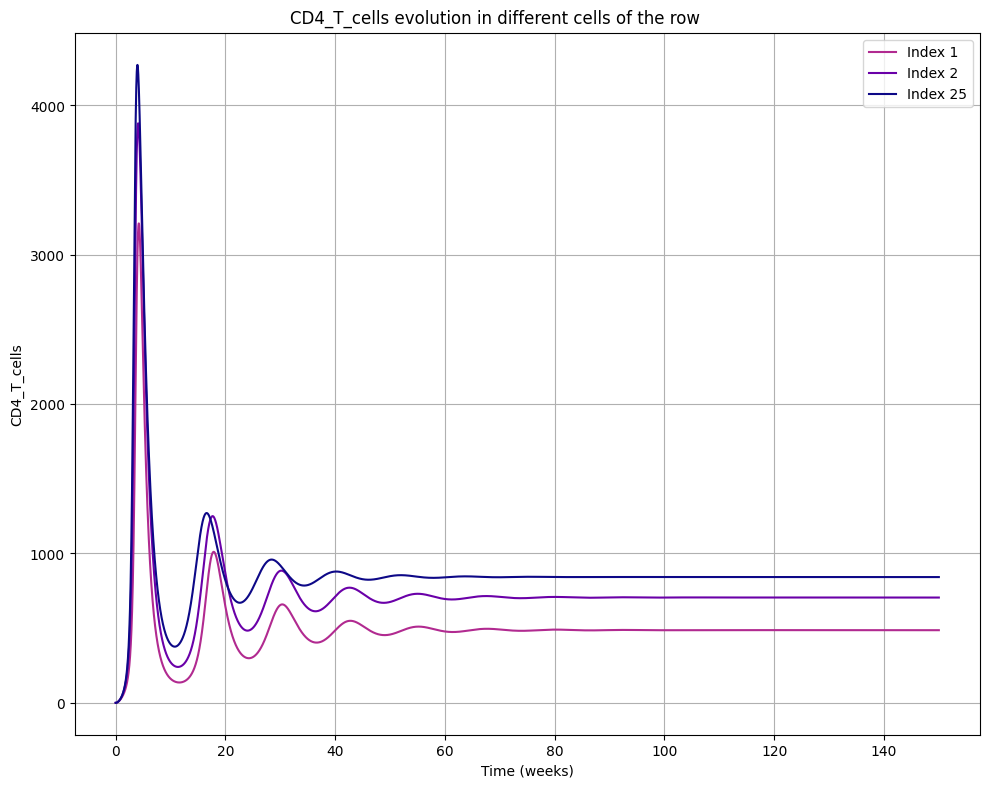

In [29]:
which_var = 0

fig, axes = plt.subplots(1, 1, figsize=(10, 8), sharex=True)

axes.plot(t, cell_1[which_var], label=f'Index 1', color=color_1)
if boundary in ['fixed_sym', 'fixed_asym', 'evolving_asym']:
    axes.plot(t, cell_2[which_var], label=f'Index 2', color=color_2)
    axes.plot(t, cell_c[which_var], label=f'Index {int(N_cells * 0.5)}', color=color_3)

axes.set_ylabel(labels[which_var])
axes.grid(True)

axes.legend()
axes.set_xlabel('Time (weeks)')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

if boundary in ['fixed_sym', 'fixed_asym', 'evolving_asym']:
    fig.suptitle(f'{labels[which_var]} evolution in different cells of the row')
else:
    fig.suptitle(f'{labels[which_var]} evolution in the second cell of the row')

if boundary in ['evolving_asym', 'fixed_asym']:
    filename = os.path.join(directory, f'{labels[which_var]}_uniform_initialisation_last_cell_exception.png')
else:
    filename = os.path.join(directory, f'{labels[which_var]}_uniform_initialisation.png')

#plt.savefig(filename)
plt.show()

This cell generates a plot of the values that the state variables assume in all the cells of the row at the end of their evolution (configuration at t_max).

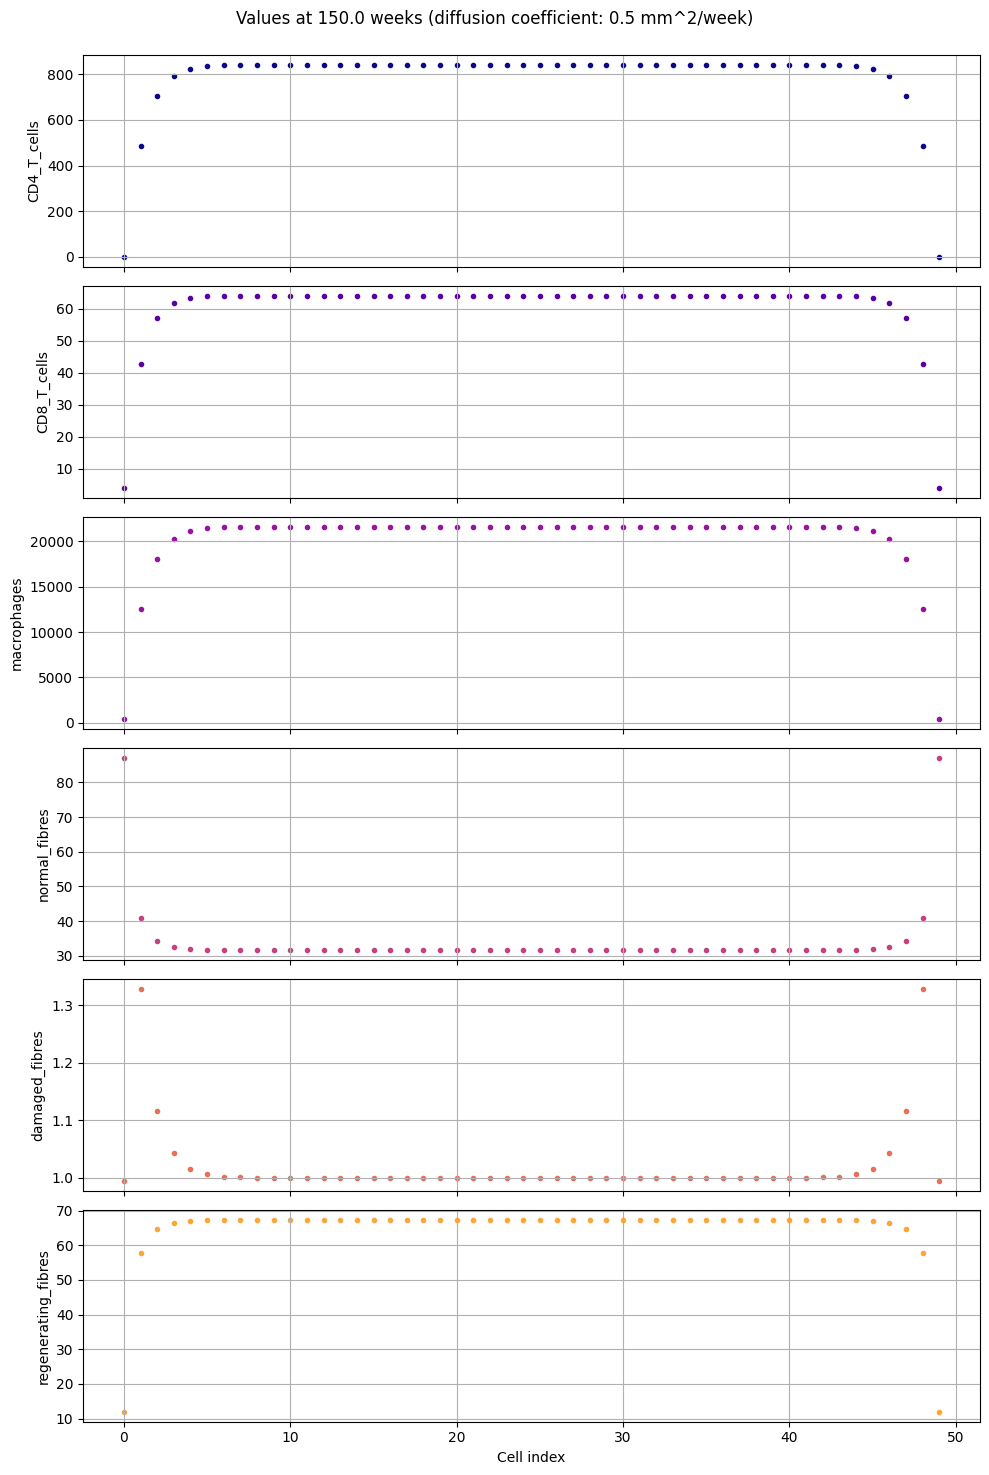

In [30]:
cells = np.linspace(0, N_cells, N_cells+1)
values_lists = [H_values, C_values, M_values, N_values, D_values, R_values]

fig, axes = plt.subplots(N_VARS, 1, figsize=(10, 15), sharex=True)
cmap = plt.cm.plasma
colors = cmap(np.linspace(0., 0.8, N_VARS))

for i, ax in enumerate(axes):
    for j in range(N_cells):
        ax.scatter(cells[j], values_lists[i][-1][j], color=colors[i], marker='.')
    ax.set_ylabel(labels[i])
    ax.grid(True)

axes[-1].set_xlabel('Cell index')

fig.suptitle(f'Values at {t_max} weeks (diffusion coefficient: {diffusion[0]} mm^2/week)')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

filename = os.path.join(directory, f'values_across_the_rowat_{t_max}.png')

#plt.savefig(filename)

plt.show()

Once again, the following cells are intended solely to generate simpler plots for inclusion in the thesis presentation. As in the previous example, they show only the final configuration of one of the state variables (defined by which_var) with respect to the cell index.

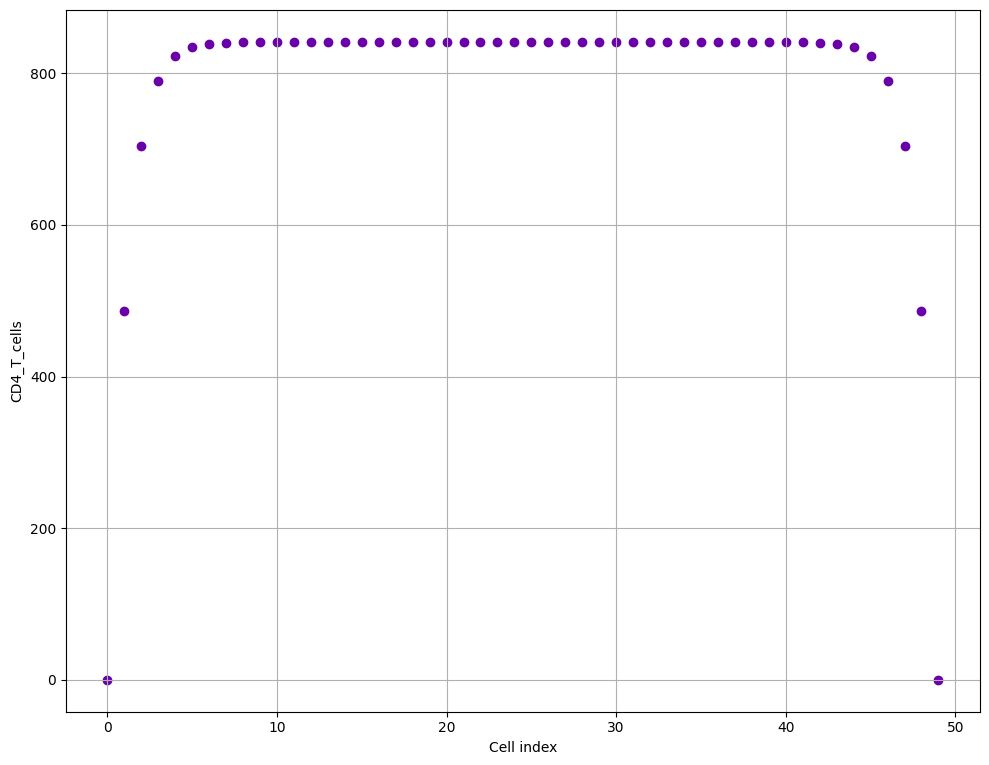

In [31]:
which_var = 0

cells = np.linspace(0, N_cells, N_cells+1)
values_lists = [H_values, C_values, M_values, N_values, D_values, R_values]

fig, axes = plt.subplots(1, 1, figsize=(10, 8), sharex=True)

for j in range(N_cells):
    axes.scatter(cells[j], values_lists[which_var][-1][j], color = color_2, marker='o')

axes.set_ylabel(labels[which_var])
axes.grid(True)

axes.set_xlabel('Cell index')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

filename = os.path.join(directory, f'{labels[which_var]} values_across_the_row_at_{t_max}.png')
#plt.savefig(filename)

plt.show()